# Building Scores for 311 requests

In this notebook we have taken the 311 requests dataset from OpenBaltimore and built a standard score based on the agency to which requests were made. 

In [39]:
import pandas as pd
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10, 10)
import folium
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})

In [2]:
df = pd.read_csv('311_Customer_Service_Requests.csv', low_memory=False)

In [3]:
df.columns

Index(['SRRecordID', 'ServiceRequestNum', 'SRType', 'MethodReceived',
       'CreatedDate', 'SRStatus', 'StatusDate', 'DueDate', 'CloseDate',
       'Agency', 'LastActivity', 'LastActivityDate', 'Outcome', 'Address',
       'ZipCode', 'Neighborhood', 'CouncilDistrict', 'PoliceDistrict',
       'PolicePost', 'Latitude', 'Longitude', 'GeoLocation'],
      dtype='object')

#### Remove all the unnecessary columns

In [4]:
df.drop(columns=['SRRecordID', 'ServiceRequestNum', 'LastActivity', 'LastActivityDate', 'Outcome', 'StatusDate', 'DueDate', 'CloseDate', 'GeoLocation', 'MethodReceived', 'PolicePost', 'CouncilDistrict', 'Address'], axis=1, inplace=True)

In [5]:
df.Latitude.dropna(inplace=True)
df.Longitude.dropna(inplace=True)

In [6]:
df.head()

,SRType,CreatedDate,SRStatus,Agency,ZipCode,Neighborhood,PoliceDistrict,Latitude,Longitude
0,TRS-Parking Complaint,01/01/2014 12:12:26 AM,Closed,Transportation,21230,Federal Hill,Southern,39.278549,-76.613462
1,TRS-Parking Complaint,01/01/2014 12:12:36 AM,Closed (Duplicate),Transportation,21230,Federal Hill,Southern,39.278549,-76.613448
2,TRS-Parking Complaint,01/01/2014 12:14:22 AM,Closed (Duplicate),Transportation,21230,Federal Hill,Southern,39.278549,-76.613462
3,TRS-Parking Complaint,01/01/2014 12:50:22 AM,Closed,Transportation,21230,Locust Point,Southern,39.268387,-76.588121
4,SW-Fire Debris Removal,01/01/2014 12:51:31 AM,Closed,Solid Waste,21215,Central Park Heights,Northwestern,39.345374,-76.676892


In [7]:
print(str(df.head(1)['CreatedDate']))

0    01/01/2014 12:12:26 AM
Name: CreatedDate, dtype: object


#### We have to convert the datatype of the CreatedDate to datetime and also remove the time as we are concerned only with dates

In [8]:
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], cache=True)

In [9]:
df['CreatedDate'] = df['CreatedDate'].dt.normalize()

In [10]:
df.columns

Index(['SRType', 'CreatedDate', 'SRStatus', 'Agency', 'ZipCode',
       'Neighborhood', 'PoliceDistrict', 'Latitude', 'Longitude'],
      dtype='object')

In [11]:
df.ZipCode.value_counts()

21218          258866
21224          255856
21217          241899
21215          240990
21213          237119
21223          199987
21230          188264
21216          187399
21229          171696
21206          135111
21202          119880
21205           98957
21231           95104
21239           91656
21211           91480
21214           88679
21212           88535
21225           74589
21201           74116
21207           48697
21209           29218
21234           28221
21210           25621
21226           18406
21222           14560
21223,21223      7653
21208            6563
21227            6544
21228            6116
21237            5119
                ...  
21244-3035          1
21224-1850          1
21214-1751          1
21224-2627          1
21211-1727          1
21224-3659          1
21222-4003          1
22120-5             1
21136-3028          1
20878               1
21215-3305          1
21210-2124          1
21213-3621          1
21212-4653          1
21217-3627

#### After looking at all the zipcodes we notice some irregularities, hence we did some cleaning of Zipcode

In [12]:
len(df.ZipCode.unique())

1647

In [13]:
df.ZipCode = df.ZipCode.astype(str)
df.ZipCode = df.ZipCode.str[0:5]

In [14]:
df.head()

,SRType,CreatedDate,SRStatus,Agency,ZipCode,Neighborhood,PoliceDistrict,Latitude,Longitude
0,TRS-Parking Complaint,2014-01-01,Closed,Transportation,21230,Federal Hill,Southern,39.278549,-76.613462
1,TRS-Parking Complaint,2014-01-01,Closed (Duplicate),Transportation,21230,Federal Hill,Southern,39.278549,-76.613448
2,TRS-Parking Complaint,2014-01-01,Closed (Duplicate),Transportation,21230,Federal Hill,Southern,39.278549,-76.613462
3,TRS-Parking Complaint,2014-01-01,Closed,Transportation,21230,Locust Point,Southern,39.268387,-76.588121
4,SW-Fire Debris Removal,2014-01-01,Closed,Solid Waste,21215,Central Park Heights,Northwestern,39.345374,-76.676892


#### Upon fixing the Zipcodes, our three key columns are CreatedDate, ZipCode and Agency. So we remove rest of the columns

In [15]:
df.drop(columns=['SRStatus', 'PoliceDistrict', 'Neighborhood', 'Latitude', 'Longitude'], axis=1,inplace=True)

In [16]:
df.columns

Index(['SRType', 'CreatedDate', 'Agency', 'ZipCode'], dtype='object')

#### We then analyze the number of requests coming from each agency for a particular zipcode on a day. This gives us an idea of which agencies are busy on which days.

In [17]:
grouped_data = df.groupby([ 'CreatedDate', 'Agency', 'ZipCode']).count()

In [18]:
grouped_data = grouped_data.reset_index()

In [19]:
grouped_data.head()

,CreatedDate,Agency,ZipCode,SRType
0,2014-01-01,BGE,21201,5
1,2014-01-01,BGE,21206,2
2,2014-01-01,BGE,21207,2
3,2014-01-01,BGE,21208,1
4,2014-01-01,BGE,21209,2


#### Since our scores should be relative to the requests coming for each agency, we create a pivot table based on the Agency column. This will generate a data frame with a column for each Agency containing counts of requests on a particular date at a particular zipcode

In [20]:
pivoted_data = grouped_data.pivot_table('SRType',['CreatedDate','ZipCode'],'Agency')

In [21]:
pivoted_data.fillna(0, inplace=True)

In [22]:
pivoted_data.head()

Agency               BCIT  BGE  Call Center  City Council  Finance  \
CreatedDate ZipCode                                                  
2014-01-01  21093     0.0  0.0          0.0           0.0      0.0   
            21201     0.0  5.0          0.0           0.0      0.0   
            21202     0.0  0.0          0.0           0.0      0.0   
            21205     0.0  0.0          0.0           0.0      0.0   
            21206     0.0  2.0          0.0           0.0      0.0   

Agency               Fire Department  General Services  Health  Housing  \
CreatedDate ZipCode                                                       
2014-01-01  21093                0.0               0.0     0.0      0.0   
            21201                0.0               0.0     0.0      0.0   
            21202                0.0               0.0     0.0      3.0   
            21205                1.0               0.0     0.0      0.0   
            21206                0.0               0.0     4.0      7.0   

Agency               Liquor Board  Mayor's Office  Parking Authority  \
CreatedDate ZipCode                                                    
2014-01-01  21093             0.0             0.0                0.0   
            21201             0.0             0.0                0.0   
            21202             0.0             0.0                0.0   
            21205             0.0             0.0                0.0   
            21206             0.0             0.0                0.0   

Agency               Police Department  Public Works  Recreation & Parks  \
CreatedDate ZipCode                                                        
2014-01-01  21093                  0.0           0.0                 0.0   
            21201                  0.0           0.0                 0.0   
            21202                  0.0           0.0                 0.0   
            21205                  0.0           0.0                 0.0   
            21206                  0.0           0.0                 0.0   

Agency               Solid Waste  Transportation  Water Wastewater  
CreatedDate ZipCode                                                 
2014-01-01  21093            0.0             0.0               1.0  
            21201           15.0             1.0               1.0  
            21202            5.0             3.0               2.0  
            21205          132.0             1.0               1.0  
            21206           18.0             2.0               0.0

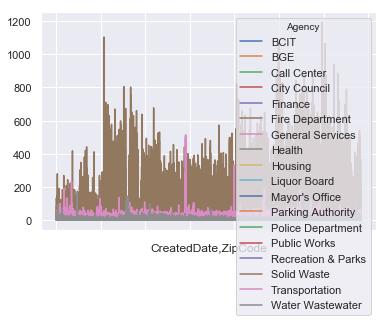

In [23]:
pivoted_data.plot()

#### Looking at the graph we notice that there are spikes in requests during the summer. And generally the Waster Water management agency is busier than the rest of the agencies.

In [24]:
pivoted_data = pivoted_data.reset_index()

In [25]:
pivoted_data.head()

Agency,CreatedDate,ZipCode,BCIT,BGE,Call Center,City Council,Finance,Fire Department,General Services,Health,Housing,Liquor Board,Mayor's Office,Parking Authority,Police Department,Public Works,Recreation & Parks,Solid Waste,Transportation,Water Wastewater
0,2014-01-01,21093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2014-01-01,21201,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,1.0,1.0
2,2014-01-01,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,2.0
3,2014-01-01,21205,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0,1.0,1.0
4,2014-01-01,21206,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,2.0,0.0


#### Now that we have the counts of requests for agencies, we need to normalize them into scores ranging from 0-10. We do that by using the 90 percentile value and then scale it down to 0 to 10. Since higher count means lower score, we subtract the division of count and the percentile value from 10.

In [26]:
pivoted_data['sw_score'] = 10 - (pivoted_data['Solid Waste']/pivoted_data['Solid Waste'].quantile(0.9))*10
pivoted_data['ww_score'] = 10 - (pivoted_data['Water Wastewater']/pivoted_data['Water Wastewater'].quantile(0.9))*10
pivoted_data['fd_score'] = 10 - (pivoted_data['Fire Department']/pivoted_data['Fire Department'].quantile(0.9))*10
pivoted_data['bge_score'] = 10 - (pivoted_data['BGE']/pivoted_data['BGE'].quantile(0.9))*10
pivoted_data['he_score'] = 10 - (pivoted_data['Health']/pivoted_data['Health'].quantile(0.9))*10
pivoted_data['ho_score'] = 10 - (pivoted_data['Housing']/pivoted_data['Housing'].quantile(0.9))*10

#### All negative values are given the score of 0 as their counts are essentially worse than the 90 percentile value

In [27]:
def less_than_zero(score):
    if score <= 0:
        return 0
    else:
        return score

In [28]:
pivoted_data.sw_score = pivoted_data.sw_score.apply(less_than_zero)
pivoted_data.ww_score = pivoted_data.ww_score.apply(less_than_zero)
pivoted_data.fd_score = pivoted_data.fd_score.apply(less_than_zero)
pivoted_data.bge_score = pivoted_data.bge_score.apply(less_than_zero)
pivoted_data.he_score = pivoted_data.he_score.apply(less_than_zero)
pivoted_data.ho_score = pivoted_data.ho_score.apply(less_than_zero)

In [29]:
pivoted_data.head(4)

Agency,CreatedDate,ZipCode,BCIT,BGE,Call Center,City Council,Finance,Fire Department,General Services,Health,...,Recreation & Parks,Solid Waste,Transportation,Water Wastewater,sw_score,ww_score,fd_score,bge_score,he_score,ho_score
0,2014-01-01,21093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,10.000000,8.888889,10.0,10.0,10.0,10.000000
1,2014-01-01,21201,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,1.0,1.0,7.500000,8.888889,10.0,0.0,10.0,10.000000
2,2014-01-01,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,3.0,2.0,9.166667,7.777778,10.0,10.0,10.0,8.421053
3,2014-01-01,21205,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,132.0,1.0,1.0,0.000000,8.888889,5.0,10.0,10.0,10.000000


#### Now that we have all the scores, lets remove the columns with the counts.

In [30]:
pivoted_data.drop(columns=["Recreation & Parks", 'Transportation', 'BGE', 'Fire Department', 'Health', 'Housing', 'Solid Waste', 'Water Wastewater'], inplace=True)

In [ ]:
pivoted_data.drop(columns=["Mayor's Office", 'Parking Authority', 'Finance'], inplace=True)

In [32]:
pivoted_data.head()

Agency,CreatedDate,ZipCode,BCIT,Call Center,City Council,Finance,General Services,Liquor Board,Mayor's Office,Parking Authority,Police Department,Public Works,sw_score,ww_score,fd_score,bge_score,he_score,ho_score
0,2014-01-01,21093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000000,8.888889,10.0,10.0,10.0,10.000000
1,2014-01-01,21201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.500000,8.888889,10.0,0.0,10.0,10.000000
2,2014-01-01,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.166667,7.777778,10.0,10.0,10.0,8.421053
3,2014-01-01,21205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8.888889,5.0,10.0,10.0,10.000000
4,2014-01-01,21206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,10.000000,10.0,5.0,2.0,6.315789


#### Then we compute the average score from the scores generated for each agency

In [33]:
pivoted_data['avg_score'] = pivoted_data[['sw_score', 'ww_score', 'fd_score', 'bge_score', 'he_score', 'ho_score']].mean(axis=1)

In [34]:
pivoted_data.head()

Agency,CreatedDate,ZipCode,BCIT,Call Center,City Council,Finance,General Services,Liquor Board,Mayor's Office,Parking Authority,Police Department,Public Works,sw_score,ww_score,fd_score,bge_score,he_score,ho_score,avg_score
0,2014-01-01,21093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.000000,8.888889,10.0,10.0,10.0,10.000000,9.814815
1,2014-01-01,21201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.500000,8.888889,10.0,0.0,10.0,10.000000,7.731481
2,2014-01-01,21202,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.166667,7.777778,10.0,10.0,10.0,8.421053,9.227583
3,2014-01-01,21205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,8.888889,5.0,10.0,10.0,10.000000,7.314815
4,2014-01-01,21206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,10.000000,10.0,5.0,2.0,6.315789,6.719298


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


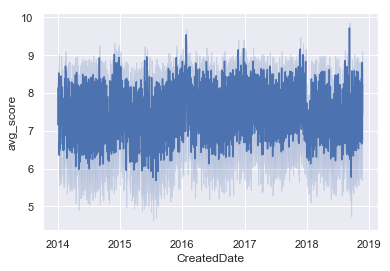

In [35]:
sns.lineplot(data=pivoted_data, x='CreatedDate',y='avg_score')

#### After generating the scores, we write to a file which will be used for calculating the cummulative score for getting the quality of life.

In [36]:
pivoted_data.loc[:, ['CreatedDate', 'ZipCode', 'avg_score']].to_csv('311_scores.csv',index=False)

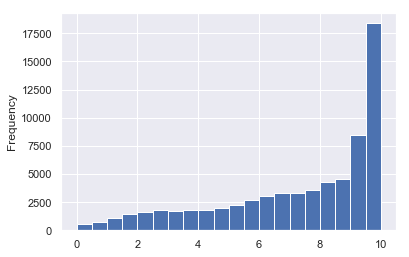

In [38]:
pivoted_data['avg_score'].plot.hist([0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10])

#### We can notice that we have a lot of areas with high scores, this infers that areas with high scores are either better in terms of infrastructure, water services and electricity, or people in these areas don't raise many requests( highly unlikely).
#### We will see the impact of scores generated from 311 requests on the cummulative scores in the final notebook.